In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/rz14/Documents/QR_Qishi/QishiQR/')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *

from Utils.lm import gen_strategy, LM_model

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']

model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

# Build Strategy

In [8]:
ASSET = 'bu'
ASSET_PATH = Path(config['Output path'], ASSET)
ASSET_PATH.mkdir(exist_ok=True, parents=True)

commodity = ASSET
exp_list = ['1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1611', '1612', '1701',
                '1702', '1703', '1704', '1705', '1706', '1709', '1712']

# === Main Routine ===
try:
    strategy = pd.read_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET))
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)
except:
    strategy = gen_strategy(commodity, exp_list, number_of_states, model_order, data_root_dir=DATA_DIR, output=OUTPUT_DIR)
    strategy.to_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET),index=False)
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

# Validate

In [9]:
import pandas as pd
from Backtesting.Vectorized.lm_validation import LmValidation

lm_validation = LmValidation(slm, symbol='bu*', data_dir=r'../../Output', valid_dir=r'../../Validation', max_order=8)
lm_validation.run()

# Test one contract

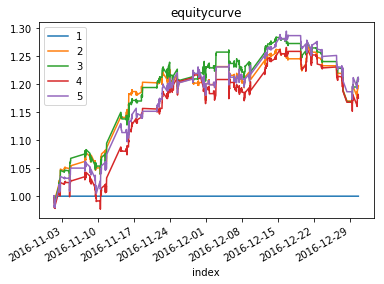

In [14]:
from Backtesting.Vectorized.models import OneContractTest
start = '20161101'
end = '20161231'
max_order=5
test1 = OneContractTest(DATA_DIR, OUTPUT_DIR, slm)
test1.build('bu', '1701', max_order, freq, offset, start, end, 'fixed')
test1.run()
test1.plot()

# Compare different contracts

# fixed cost

In [27]:
from Backtesting.Vectorized.models import MultiContractTest
start = '20161101'
end = '20161231'
exps=['1701','1702', '1703', '1704', '1705', '1706', '1709', '1712']
tcas = ['fixed']*len(exps)

test2 = MultiContractTest(DATA_DIR, OUTPUT_DIR, slm)
test2.build('bu', exps, 4, freq, offset, start, end, tcas)
test2.run()

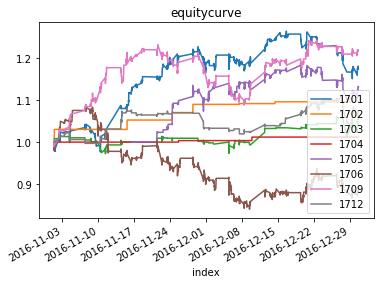

In [28]:
test2.plot()
plt.legend(exps)

In [29]:
test2.performance.index=exps
test2.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
1701,0.332129,0.003980,-0.004279,0.002460,0.000147,-0.042453,0.055136,-0.089896,0.574938,2.995561,1189,1.175105,0.391926
1702,0.106249,0.002189,NaN,0.016054,0.001661,0.000000,0.030417,0.000000,NaN,5.150929,58,1.096321,0.103448
1703,0.169137,0.001249,-0.005311,0.004290,0.000151,-0.044206,0.029853,-0.045525,0.807668,1.845651,364,1.054941,0.195055
1704,0.021862,0.000279,NaN,0.006007,0.000924,0.000000,0.008403,0.000000,NaN,3.194887,13,1.012014,0.153846
1705,0.284538,0.003988,-0.004297,0.002813,0.000190,-0.036313,0.020708,-0.073624,0.654675,3.504342,692,1.131620,0.365607
1706,0.308431,-0.002679,-0.004501,0.002190,-0.000085,-0.037608,0.026412,-0.224886,0.486682,-2.171091,1363,0.884823,0.418195
1709,0.319679,0.004971,-0.003997,0.002375,0.000193,-0.043668,0.028085,-0.116831,0.594300,3.887599,1132,1.218730,0.414311
1712,0.218285,0.001569,-0.004790,0.003182,0.000156,-0.043062,0.017153,-0.057894,0.664440,1.796544,443,1.069020,0.259594


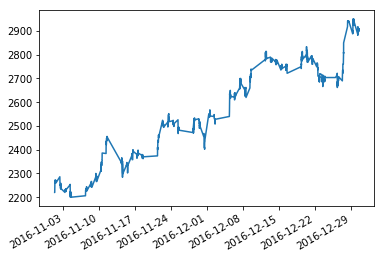

In [20]:
test2.test_data[-1].LastPrice.plot()

# Spread cost

In [24]:
from Backtesting.Vectorized.models import MultiContractTest
start = '20161101'
end = '20161231'
exps=['1701','1702', '1703', '1704', '1705', '1706', '1709', '1712']
tca = ['Spread']*len(exps)

test2 = MultiContractTest(DATA_DIR, OUTPUT_DIR, slm)
test2.build('bu', exps, 4, freq, offset, start, end, tca)
test2.run()

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.339980,-0.015601,-0.003131,0.002096,-0.000577,-0.049439,0.054602,-0.686460,0.669320,-11.472277,1189,0.313540,0.343987
1,0.129852,-0.003921,-0.007445,0.004203,-0.002975,-0.014676,0.008006,-0.174264,0.564626,-7.549789,58,0.827457,0.086207
2,0.259847,-0.020767,-0.005602,0.003228,-0.002510,-0.065422,0.020460,-0.913766,0.576145,-19.980399,364,0.086234,0.104396
3,0.107757,-0.001522,-0.011182,0.001664,-0.005033,-0.021827,0.001664,-0.065430,0.148773,-3.530237,13,0.934570,0.076923
4,0.448026,-0.036120,-0.004379,0.002360,-0.001723,-0.052815,0.020033,-1.193761,0.538930,-20.155271,692,-0.191971,0.232659
5,0.348233,-0.022015,-0.003548,0.001829,-0.000695,-0.040277,0.026017,-0.951809,0.515530,-15.804956,1363,0.053345,0.387381
6,0.367930,-0.024977,-0.003499,0.001952,-0.000971,-0.045733,0.027711,-1.101462,0.557769,-16.971032,1132,-0.098971,0.319788
7,0.285206,-0.021738,-0.004870,0.002210,-0.002159,-0.054428,0.010701,-0.956463,0.453902,-19.054472,443,0.043537,0.142212


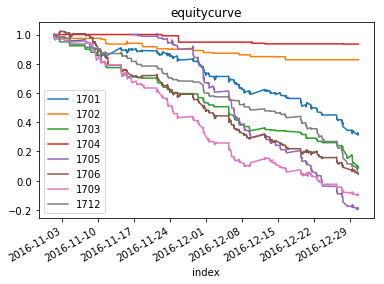

In [26]:
test2.plot()
plt.legend(exps)
test2.performance